In [1]:
try:
    import pymc as pm
except:
    %pip install pymc==5.8.0    
    import pymc as pm
    
print(pm.__version__)

try:
    import pymc_bart as pmb
except:
    %pip install pymc-bart
    import pymc_bart as pmb
    

print(pmb.__version__)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import os
import pickle

import boto3
from sagemaker import get_execution_role
import xgboost

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


5.8.0
0.5.1


In [2]:
# configure training/testing environment
DKU_DST_ap_data_sector = 'SOY_NA_SUMMER'
DKU_DST_analysis_type = 'SingleExp'

tree_fname = 'BART_real_data_forest_20trees_50draws_2chains_classbalanced.pkl' # filename
data_fname = 'BART_real_test_data.pkl'

# useful functions
def get_predictions_from_trees(forests, x_te):
    # sample from each forest in forests
    # forests is a list of a list.
    # the outer list contains each forest
    # each forest contains trees. Average predictions from each tree in a forest, output each forest prediction
    # output is x_te.shape[0] x N_forests
    
    pred_out = np.zeros((x_te.shape[0], len(forests)))
    for i_forest in range(len(forests)):
        trees = forests[i_forest]
        temp_pred = 0
        for tree in trees:
            temp_pred += tree.predict(x_te)
        pred_out[:,i_forest] = temp_pred
    return pred_out

def invlogit(x):
    return 1/(1+np.exp(-x))

def sample_posterior(forests, x_te):
    forest_pred = get_predictions_from_trees(forests,x_te)
    return invlogit(forest_pred)

with open(data_fname,'rb') as f:
    train_test_data = pickle.load(f)

x_tr = train_test_data['x_tr']
y_tr = train_test_data['y_tr']
x_te = train_test_data['x_te']
y_te = train_test_data['y_te']
in_cols = train_test_data['in_cols']

with open(tree_fname,'rb') as f:
    forest_data = pickle.load(f)
forests = forest_data['forests']
#in_cols = forest_data['in_cols'] # saved in multiple places currently

[[23896  4191]
 [  973  2027]]


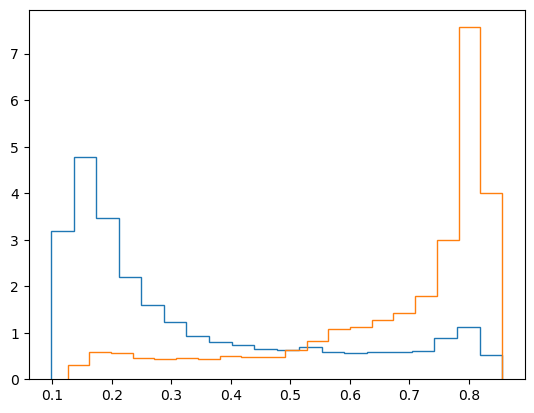

In [4]:
# xgboost (as a control):
# train xgb model
xgb_params = {'max_depth':5,
              'reg_lambda':100,
              'subsample':0.2,
              'learning_rate':0.005,
              'n_estimators':500,
             'scale_pos_weight':np.sum(y_tr==0)/np.sum(y_tr==1),
             'gamma':10,
             'booster':'gbtree'}

xgb_mdl = xgboost.XGBClassifier(**xgb_params)
xgb_mdl.fit(x_tr,y_tr)

# test xgb model
y_proba = xgb_mdl.predict_proba(x_te)[:,1]

plt.figure()
plt.hist(y_proba[y_te==0],bins=20,histtype='step',density=True)
plt.hist(y_proba[y_te==1],bins=20,histtype='step',density=True)

print(confusion_matrix(y_true=y_te, y_pred=y_proba>np.percentile(y_proba,80)))

[[23824  4263]
 [ 1045  1955]]


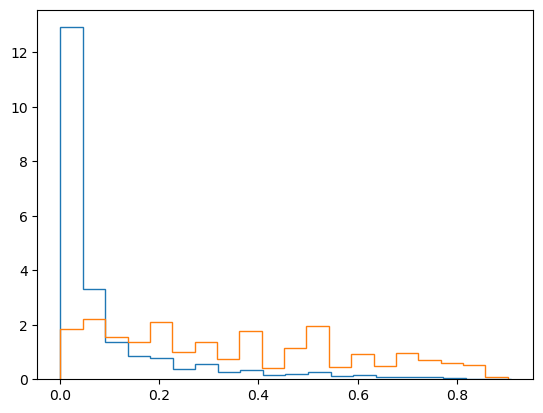

In [5]:
# BART test model
x_in = x_te
y_in = y_te

pred_per_forest = sample_posterior(forests,x_in)
pred_mean = np.mean(pred_per_forest,axis=1)

plt.figure()
plt.hist(pred_mean[y_in==0],histtype='step',bins=20,density=True);
plt.hist(pred_mean[y_in==1],histtype='step',bins=20,density=True);
print(confusion_matrix(y_true=y_te, y_pred=pred_mean>np.percentile(pred_mean,80)))

In [6]:
split_var_count = {}
for i in range(x_tr.shape[1]):
    split_var_count[i] = 0
    
for i in range(len(forests)):
    for j in range(len(forests[i])):
        for split_var in forests[i][j].get_split_variables():
            split_var_count[split_var] = split_var_count[split_var] + 1

for i in range(x_tr.shape[1]):
    print(in_cols[i], split_var_count[i])

result_diff_PLHTN 850
result_diff_IC__N 648
result_diff_MRTYN 635
result_diff_EMRGR 628
result_diff_SBSSN 330
result_diff_YGSMN 1222
result_diff_HLDGR 580
result_diff_FL_CR 597
result_diff_GLU_R 1786
result_diff_HVAPR 927
result_diff_MI__R 1118
result_diff_PD_CR 1286
result_diff_RUR_R 906


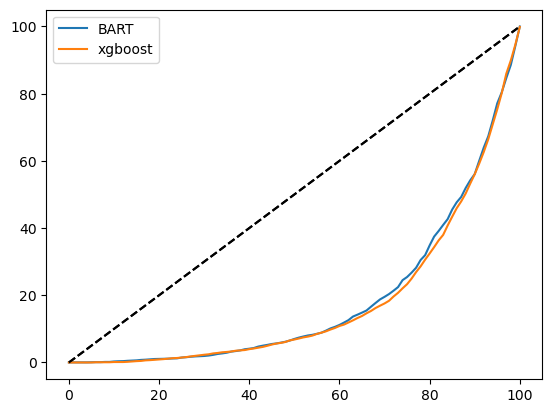

In [7]:
# percentile rejection/acceptance curves comparing BART and xgboost
plt.figure()
step = 1
plot_reject=1

for predictions,mdl_name in zip([pred_mean, y_proba],['BART','xgboost']):
    perc_mats = []
    perc_advanced = []
    for perc in range(0,100+step,step):
        
        
        if plot_reject==1:
            perc_mats.append(perc)
            predictions_relative_to_perc = predictions < np.percentile(predictions,perc)
        else:
            perc_mats.append(100-perc)
            predictions_relative_to_perc = predictions >= np.percentile(predictions,perc)
        perc_advanced.append(100*np.sum((y_te==1) & (predictions_relative_to_perc))/np.sum(y_te))

        
    plt.plot(perc_mats, perc_advanced,label=mdl_name)
    plt.plot([0,100],[0,100],'k--')
    plt.legend()


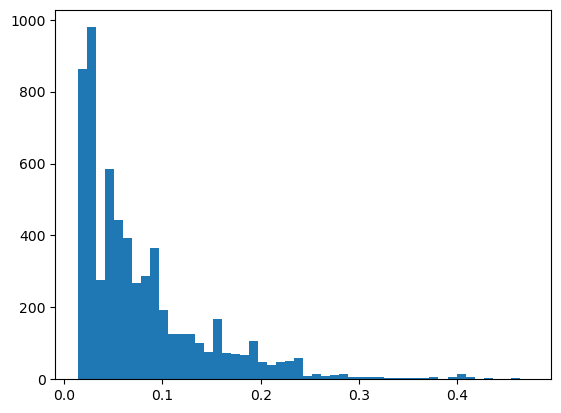

In [44]:
mask=pred_mean>0.2
interval_max = np.percentile(pred_per_forest,90,axis=1)
interval_min = np.percentile(pred_per_forest,10,axis=1)
interval_width=interval_max-interval_min
plt.hist(interval_width[mask],bins=50);

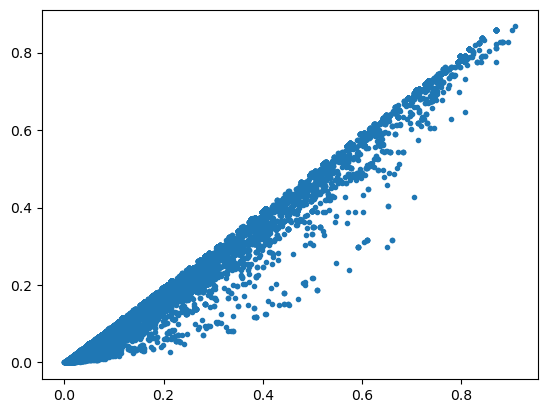

In [46]:
plt.plot(pred_mean, interval_min,'.')

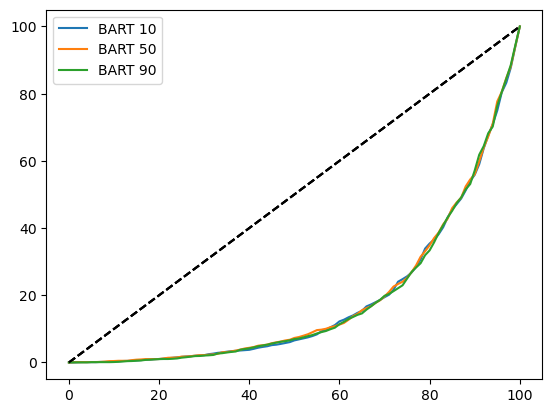

In [26]:
# percentile rejection/acceptance curves comparing BART and xgboost
plt.figure()
step = 1
plot_reject=1

credibility_interval_percentiles = [10,50,90]

pred_percentiles = [np.percentile(pred_per_forest,perc,axis=1) for perc in credibility_interval_percentiles]
mdl_names = ['BART ' + str(perc) for perc in credibility_interval_percentiles]

for predictions,mdl_name in zip(pred_percentiles,mdl_names):
    perc_mats = []
    perc_advanced = []
    for perc in range(0,100+step,step):
        
        
        if plot_reject==1:
            perc_mats.append(perc)
            predictions_relative_to_perc = predictions < np.percentile(predictions,perc)
        else:
            perc_mats.append(100-perc)
            predictions_relative_to_perc = predictions >= np.percentile(predictions,perc)
        perc_advanced.append(100*np.sum((y_te==1) & (predictions_relative_to_perc))/np.sum(y_te))

        
    plt.plot(perc_mats, perc_advanced,label=mdl_name)
    plt.plot([0,100],[0,100],'k--')
    plt.legend()


In [16]:
# prediction as a function of inputs
#for i,col in enumerate(in_cols):
    #plt.figure()
    #plt.plot(x_te[:,i], pred_mean,'.')
    #plt.title(col)

Text(0, 0.5, 'std prediction')

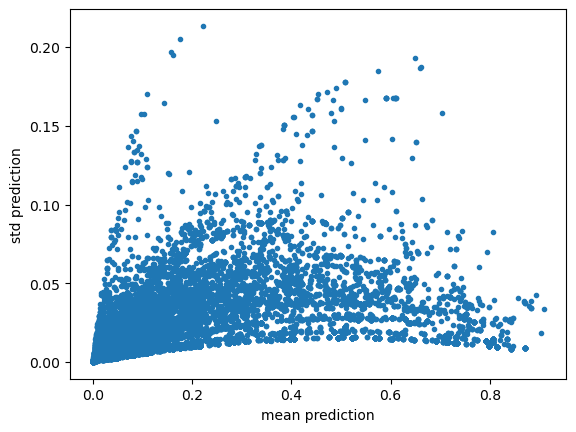

In [11]:
# credibility interval...
plt.plot(np.mean(pred_per_forest,axis=1), np.std(pred_per_forest,axis=1), '.')
plt.xlabel('mean prediction')
plt.ylabel('std prediction')

array([0.10931288, 0.10931288, 0.25747819, ..., 0.02878089, 0.04242109,
       0.04760135])

In [29]:
# credibility interval....test bounds?
pred_vals = np.percentile(pred_per_forest,90,axis=1)
print(confusion_matrix(y_true=y_te, y_pred=pred_vals>np.percentile(pred_mean,50)))

[[ 6445 21642]
 [   33  2967]]


In [30]:
2967/(201+2799)

0.989

In [ ]:
# shap values?

[[23896  4191]
 [  973  2027]]


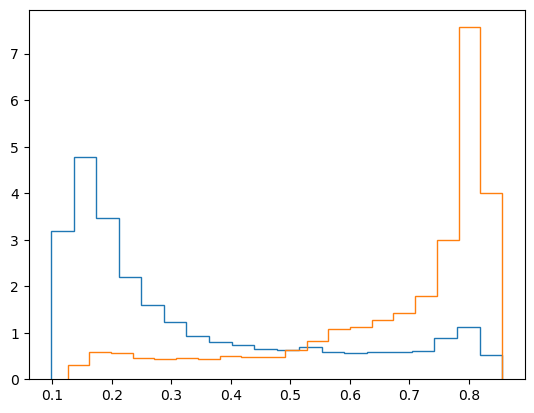

In [9]:
# xgboost (as a control):
# train xgb model
xgb_params = {'max_depth':5,
              'reg_lambda':100,
              'subsample':0.2,
              'learning_rate':0.005,
              'n_estimators':500,
             'scale_pos_weight':np.sum(y_tr==0)/np.sum(y_tr==1),
             'gamma':10,
             'booster':'gbtree'}

xgb_mdl = xgboost.XGBClassifier(**xgb_params)
xgb_mdl.fit(x_tr,y_tr)

# test xgb model
y_proba = xgb_mdl.predict_proba(x_te)[:,1]

plt.figure()
plt.hist(y_proba[y_te==0],bins=20,histtype='step',density=True)
plt.hist(y_proba[y_te==1],bins=20,histtype='step',density=True)

print(confusion_matrix(y_true=y_te, y_pred=y_proba>np.percentile(y_proba,80)))